
# Unit 2 — Team Classification (Titanic, BQML)

**Goal (team):** Build an *ops-ready* classifier in **BigQuery ML** to predict **`survived`** on the Titanic dataset. Requirements mirror the Flights notebook for comparability.
    
**Dataset:** `bigquery-public-data.ml_datasets.titanic`

**Deliver (inside this notebook):**
- One **LOGISTIC_REG** baseline + one **engineered** model (`TRANSFORM`)
- **Evaluation** via `ML.EVALUATE` and **confusion matrices** (0.5 + custom threshold)
- **Threshold choice** + 3–5 sentence ops justification (e.g., lifeboat allocation policy in a hypothetical ops setting)
- Embedded **rubric** below


# **Dataset Setup**

In [5]:

# --- Minimal setup (edit 2 vars) ---
from google.colab import auth
auth.authenticate_user()

import os
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "mgmt467-472519"   # e.g., mgmt-467-47888
DATASET_ID = "titanic_datset"
TABLE_ID = "titanic"
TABLE_PATH = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

!pip install -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic -p /content
!unzip -o /content/titanic.zip -d /content


# Load
df = pd.read_csv("/content/train.csv")
print(df.head())

# Upload to BQ

client = bigquery.Client(project=PROJECT_ID)
client.create_dataset(DATASET_ID, exists_ok=True)
table_ref = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"
job = client.load_table_from_dataframe(df, table_ref)
job.result()



Saving kaggle.json to kaggle (1).json
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/titanic.zip
  inflating: /content/gender_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Far

LoadJob<project=mgmt467-472519, location=US, id=4e6e70c1-4fb5-4b73-911d-5bc0b5faaaab>

### Quick sanity check

In [6]:

client.query(f"SELECT * FROM `{TABLE_PATH}` LIMIT 5").result().to_dataframe()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,None,S
1,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
2,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,None,S
3,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,None,S
4,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,None,S


In [22]:
CANONICAL_BASE_SQL = f'''
CREATE OR REPLACE TABLE titanic_datset.titanic_c AS (
  SELECT
    CAST(survived AS BOOL) AS survived,
    CAST(pclass AS INT64)  AS pclass,
    CAST(sex AS STRING)    AS sex,
    CAST(age AS FLOAT64)   AS age,
    CAST(sibsp AS INT64)   AS sibsp,
    CAST(parch AS INT64)   AS parch,
    CAST(fare AS FLOAT64)  AS fare,
    CAST(embarked AS STRING) AS embarked
  FROM `{TABLE_PATH}`
  WHERE age IS NOT NULL AND fare IS NOT NULL
)

'''
print(CANONICAL_BASE_SQL[:500] + "\n...")
job = client.query(CANONICAL_BASE_SQL, location="US")


CREATE OR REPLACE TABLE titanic_datset.titanic_c AS (
  SELECT
    CAST(survived AS BOOL) AS survived,
    CAST(pclass AS INT64)  AS pclass,
    CAST(sex AS STRING)    AS sex,
    CAST(age AS FLOAT64)   AS age,
    CAST(sibsp AS INT64)   AS sibsp,
    CAST(parch AS INT64)   AS parch,
    CAST(fare AS FLOAT64)  AS fare,
    CAST(embarked AS STRING) AS embarked
  FROM `mgmt467-472519.titanic_datset.titanic`
  WHERE age IS NOT NULL AND fare IS NOT NULL
)


...


# **Train/Eval Split**

In [26]:
SPLIT_CLAUSE = f"""
ALTER TABLE titanic_datset.titanic_c
ADD COLUMN
split STRING;
"""
print(SPLIT_CLAUSE)

job = client.query(SPLIT_CLAUSE, location="US")
job.result()


ALTER TABLE titanic_datset.titanic_c
ADD COLUMN
split STRING;



In [31]:
SPLIT_UPDATE = f"""
UPDATE `{PROJECT_ID}.{DATASET_ID}.titanic_c`
SET split = CASE
  WHEN RAND() < 0.8
  THEN 'TRAIN' ELSE 'EVAL'
                 END
WHERE 'PassengerId' IS NOT NULL;
"""

job = client.query(SPLIT_UPDATE, location="US")
job.result()

# **Baseline Model**

In [33]:
# Model A

query_create = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET_ID}.manifest_baseline`
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['Survived']
) AS
SELECT
  Pclass,
  Sex,
  Age,
  Fare,
  Embarked,
  Survived
FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c`
WHERE Survived IS NOT NULL AND Age IS NOT NULL AND Fare IS NOT NULL
and split = 'TRAIN';
"""

job = client.query(query_create, location="US")
job.result()

print("✅ Logistic regression model created successfully in BigQuery!")

✅ Logistic regression model created successfully in BigQuery!


In [35]:
# Model Evaluation

evaluation_query = f"""
SELECT *
FROM ML.EVALUATE(MODEL `{PROJECT_ID}.{DATASET_ID}.manifest_baseline`,
  (SELECT survived, pclass, sex, age, sibsp, parch, fare, embarked
   FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c` WHERE split='EVAL')
   );
"""

eval_df = client.query(evaluation_query, location="US").to_dataframe()
print(eval_df)

   precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.752525  0.680365  0.791594  0.714628  0.458294  0.840771


<Figure size 500x500 with 0 Axes>

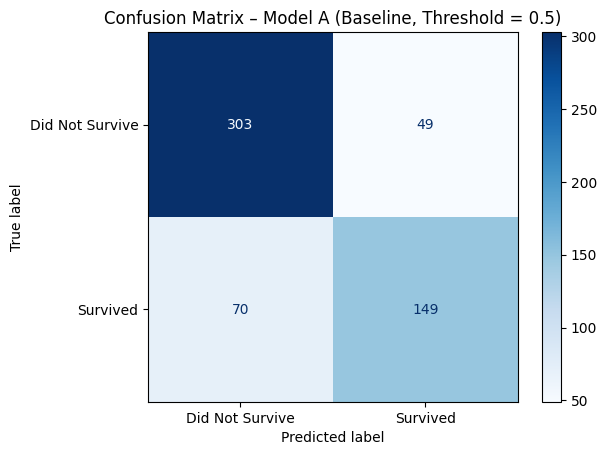

              precision    recall  f1-score   support

         0.0      0.812     0.861     0.836       352
         1.0      0.753     0.680     0.715       219

    accuracy                          0.792       571
   macro avg      0.782     0.771     0.775       571
weighted avg      0.789     0.792     0.789       571



In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


# Pull actual and predicted probabilities from the model
query_confusion = f"""
SELECT
  Survived AS actual,
  predicted_Survived_probs[OFFSET(0)].prob AS predicted_prob
FROM ML.PREDICT(
  MODEL `{PROJECT_ID}.{DATASET_ID}.manifest_baseline`,
  (SELECT * FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c`
  WHERE split = 'EVAL')
)
WHERE Survived IS NOT NULL
"""

conf_df = client.query(query_confusion, location="US").to_dataframe()

# Apply threshold 0.5
conf_df["predicted_label"] = (conf_df["predicted_prob"] >= 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(conf_df["actual"], conf_df["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Model A (Baseline, Threshold = 0.5)")
plt.grid(False)
plt.show()

# Print precision, recall, and F1
print(classification_report(conf_df["actual"], conf_df["predicted_label"], digits=3))


<Figure size 500x500 with 0 Axes>

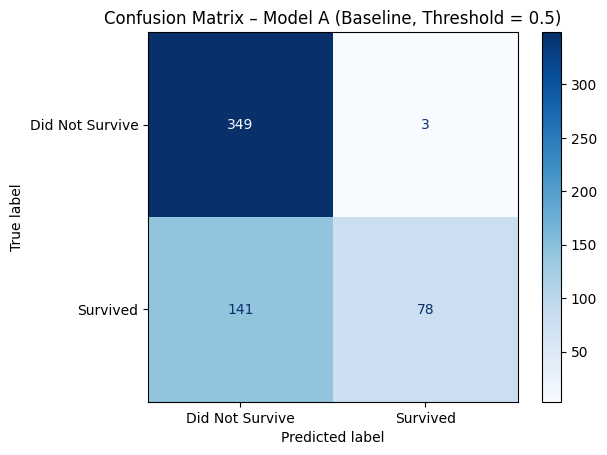

              precision    recall  f1-score   support

         0.0      0.712     0.991     0.829       352
         1.0      0.963     0.356     0.520       219

    accuracy                          0.748       571
   macro avg      0.838     0.674     0.674       571
weighted avg      0.808     0.748     0.710       571



In [45]:
# Pull actual and predicted probabilities from the model
query_confusion = f"""
SELECT
  Survived AS actual,
  predicted_Survived_probs[OFFSET(0)].prob AS predicted_prob
FROM ML.PREDICT(
  MODEL `{PROJECT_ID}.{DATASET_ID}.manifest_baseline`,
  (SELECT * FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c`
  WHERE split = 'EVAL')
)
WHERE Survived IS NOT NULL
"""

conf_df = client.query(query_confusion, location="US").to_dataframe()

# Apply threshold 0.8
conf_df["predicted_label"] = (conf_df["predicted_prob"] >= 0.8).astype(int)

# Generate confusion matrix
cm = confusion_matrix(conf_df["actual"], conf_df["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Model A (Baseline, Threshold = 0.8)")
plt.grid(False)
plt.show()

# Print precision, recall, and F1
print(classification_report(conf_df["actual"], conf_df["predicted_label"], digits=3))

## Threshold Rationale

The rationale behind a raised threshold is based on minimize passengers losses and providing a buffer of extra survival resources. Increasing the threshold means more passengers will be predicted as not surviving than there truly are which will lead to us getting a better assessment of who is very likely to survive. With this information, we can get a better idea of how many passengers will definitely not need our help.



# **Engineered Model**

## Creating Model B

In [53]:
# Model B

query_create = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET_ID}.engineered`
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['Survived']
) AS
SELECT
  (sibsp + parch + 1) AS family_size,
    CASE
    WHEN fare < 10 THEN 'low'
    WHEN fare < 50 THEN 'mid'
    ELSE 'high'
  END AS fare_bucket,
  CONCAT(sex, '_', CAST(pclass AS STRING)) AS sex_pclass,
  Pclass,
  Sex,
  Age,
  Fare,
  Embarked,
  Survived
FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c`
WHERE Survived IS NOT NULL AND Age IS NOT NULL AND Fare IS NOT NULL
and split = 'TRAIN';
"""

job = client.query(query_create, location="US")
job.result()

print("✅ Logistic regression model created successfully in BigQuery!")

✅ Logistic regression model created successfully in BigQuery!


## Evaluating Model B

In [54]:
evaluation_query = f"""
SELECT *
FROM ML.EVALUATE(MODEL `{PROJECT_ID}.{DATASET_ID}.engineered`,
  (SELECT
    (sibsp + parch + 1) AS family_size,
    CASE
    WHEN fare < 10 THEN 'low'
    WHEN fare < 50 THEN 'mid'
    ELSE 'high'
  END AS fare_bucket,
  CONCAT(sex, '_', CAST(pclass AS STRING)) AS sex_pclass,
  -- Manifest Features
  survived, pclass, sex, age, sibsp, parch, fare, embarked
   FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c` WHERE split='EVAL')
   );
"""

eval_df = client.query(evaluation_query, location="US").to_dataframe()
print(eval_df)

   precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.860927  0.593607  0.807356  0.702703  0.426719  0.864974


## Model B Confusion Matrix - 0.5 Threshold

<Figure size 500x500 with 0 Axes>

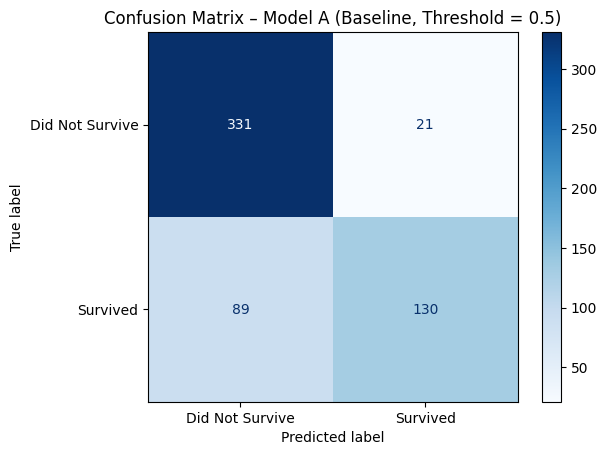

              precision    recall  f1-score   support

         0.0      0.788     0.940     0.858       352
         1.0      0.861     0.594     0.703       219

    accuracy                          0.807       571
   macro avg      0.825     0.767     0.780       571
weighted avg      0.816     0.807     0.798       571



In [56]:
query_confusion = f"""
SELECT
  Survived AS actual,
  predicted_Survived_probs[OFFSET(0)].prob AS predicted_prob
FROM ML.PREDICT(
  MODEL `{PROJECT_ID}.{DATASET_ID}.engineered`,
  (SELECT
    (sibsp + parch + 1) AS family_size,
    CASE
    WHEN fare < 10 THEN 'low'
    WHEN fare < 50 THEN 'mid'
    ELSE 'high'
  END AS fare_bucket,
  CONCAT(sex, '_', CAST(pclass AS STRING)) AS sex_pclass,
  -- Manifest Features
  survived, pclass, sex, age, sibsp, parch, fare, embarked
  FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c`
  WHERE split = 'EVAL')
)
WHERE Survived IS NOT NULL
"""

conf_df = client.query(query_confusion, location="US").to_dataframe()

# Apply threshold 0.5
conf_df["predicted_label"] = (conf_df["predicted_prob"] >= 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(conf_df["actual"], conf_df["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Model A (Baseline, Threshold = 0.5)")
plt.grid(False)
plt.show()

# Print precision, recall, and F1
print(classification_report(conf_df["actual"], conf_df["predicted_label"], digits=3))

# **Model Metric Comparison**

In [51]:
comparison = f"""
SELECT 'baseline' AS model_version, * FROM ML.EVALUATE(
  MODEL `{PROJECT_ID}.{DATASET_ID}.manifest_baseline`,
  (SELECT survived, pclass, sex, age, sibsp, parch, fare, embarked
   FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c` WHERE split='EVAL')
)
UNION ALL
SELECT 'engineered' AS model_version, * FROM ML.EVALUATE(
  MODEL `{PROJECT_ID}.{DATASET_ID}.engineered`,
  (SELECT
    (sibsp + parch + 1) AS family_size,
    CASE
    WHEN fare < 10 THEN 'low'
    WHEN fare < 50 THEN 'mid'
    ELSE 'high'
  END AS fare_bucket,
  CONCAT(sex, '_', CAST(pclass AS STRING)) AS sex_pclass,
  -- Manifest Features
  survived, pclass, sex, age, sibsp, parch, fare, embarked
   FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c` WHERE split='EVAL')
   )
"""

job = client.query(comparison, location="US")
job.result().to_dataframe()

,model_version,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,engineered,0.860927,0.593607,0.807356,0.702703,0.426719,0.864974
1,baseline,0.752525,0.680365,0.791594,0.714628,0.458294,0.840771



### Write-up (concise)
- **Threshold chosen & ops rationale:** …  
- **Baseline vs engineered — changes in AUC/precision/recall:** …  
- **Risk framing:** FP vs FN trade in a rescue/triage-like context: what error hurts more and why? …



---

## Rubric (Titanic, 100 pts)
**Team-only deliverable in this notebook**

- Baseline LOGISTIC_REG + evaluation (AUC + confusion @0.5) — **20**  
- Custom threshold confusion matrix + ops justification — **20**  
- Engineered model with `TRANSFORM` (family_size, fare_bucket, sex_pclass) — **20**  
- Comparison table (baseline vs engineered) + 3–5 sentence interpretation — **20**  
- Reproducibility: parameters clear, no hidden magic; mapping documented — **10**  
- Governance notes: assumptions/limitations + slices you would monitor — **10**

> **Strictness:** No screenshots; use actual results cells. Keep explanations concise (bullet points OK).
